### USE EQNS FROM THE CHINESE PAPER ONLY

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import dynesty as dyn
from scipy.special import ndtri
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import emcee

In [2]:
ncpu = mul.cpu_count()
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)

param_ranges_NULL = [(1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_lin = [(1e-20, 1e20), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_quad = [(1e-20, 1e15), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]


GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']


grb = GRBs[0]
grbname = grb + '.txt'
grbname_wtht_ext = grbname.replace('.txt','')


arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
data = [arr[:,0], arr[:,1], arr[:,2]]
x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]

#Properties of GRB
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
H0=67.36 #Hubble constant km -1 Mpc s -1
omega_m = 0.315
omega_l = 1 - omega_m

In [3]:
#MODELS

#NULL model
def nullhp(E, Eb, alpha1, alpha2, mu, zeta):
    
    eob = (E - E0) / Eb
    
    return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))


def int_z(z_prime, n):
    integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
    return quad( integ_fn, a=0, b=z_prime)[0]

int_z1 = np.asarray(int_z(z_com, 1))
int_z2 = np.asarray(int_z(z_com, 2))

#LINEAR model
def linearhp(E, logEqg, Eb, alpha1, alpha2, mu, zeta):
    
    e0qg = (E - E0) / (10 ** logEqg)
    
    return - (e0qg * int_z1)/H0 + nullhp(E, Eb, alpha1, alpha2, mu, zeta)

#QUADRATIC model
def quadhp(E, logEqg, Eb, alpha1, alpha2, mu, zeta):
    e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
    
    return -1.5 * (e0qg * int_z2)/H0 + nullhp(E, Eb, alpha1, alpha2, mu, zeta)

In [4]:
#LOG-LIKELIHOODS
def loglike_null(theta):
    Eb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = nullhp(x,  Eb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf

def loglike_linear(theta):
    logEqg, Eb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = linearhp(x, logEqg, Eb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf

def loglike_quad(theta):
    logEqg, Eb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = quadhp(x, logEqg, Eb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf    

In [5]:
#PRIORS

def logprior_null(theta):
    Eb, alpha1, alpha2, mu, zeta = theta
    
    if 0 < Eb < 5000 and -3 < alpha1 < 10 and -10 < alpha2 < 3 and 0 < mu < 3 and 0 < zeta < 4:
        return 0
    
    return -np.inf

def logprior_linear(theta):
    logEqg, Eb, alpha1, alpha2, mu, zeta = theta
    
    if -200 < logEqg < 20 and 0 < Eb < 5000 and -3 < alpha1 < 10 and -10 < alpha2 < 3 and 0 < mu < 3 and 0 < zeta < 4:
        return 0
    
    return -np.inf

def logprior_quad(theta):
    logEqg, Eb, alpha1, alpha2, mu, zeta = theta
    
    if -200 < logEqg < 15 and 0 < Eb < 5000 and -3 < alpha1 < 10 and -10 < alpha2 < 3 and 0 < mu < 3 and 0 < zeta < 4:
        return 0
    
    return -np.inf

In [6]:
#POSTERIORS

def logpost_null(theta):
    logp = logprior_null(theta)
    
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + loglike_null(theta)

def logpost_linear(theta):
    logp = logprior_linear(theta)
    
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + loglike_linear(theta)

def logpost_quad(theta):
    logp = logprior_quad(theta)
    
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + loglike_quad(theta)

In [7]:
#SAMPLING
nwalkers = 200
ndim_null = 5
nsteps = 10000
nburnin = 500
init_null = np.array([np.random.uniform(0, 5000, nwalkers), np.random.uniform(-3, 10, nwalkers), np.random.uniform(-10, 3, nwalkers), np.random.uniform(0, 3, nwalkers), np.random.uniform(0, 4, nwalkers)]).T

sampler0 = emcee.EnsembleSampler(nwalkers, ndim_null, logpost_null, pool=mul.Pool(8), threads=8)

sampler0.run_mcmc(init_null, nsteps, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/darkwake/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 99/10000 [00:04<07:29, 22.01it/s]/tmp/ipykernel_26144/2090075144.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/tmp/ipykernel_26144/2090075144.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  1%|          | 105/10000 [00:04<07:29, 22.00it/s]/tmp/ipykernel_26144/2090075144.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  1%|          | 117/10000 [00:05<07:09, 23.04it/s]/tmp/ipykernel_26144/2090075144.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) *

In [ ]:
results = sampler0.get_chain(discard=nburnin//5, flat=True)
truths = [results[:,i].mean() for i in range(ndim_null)]

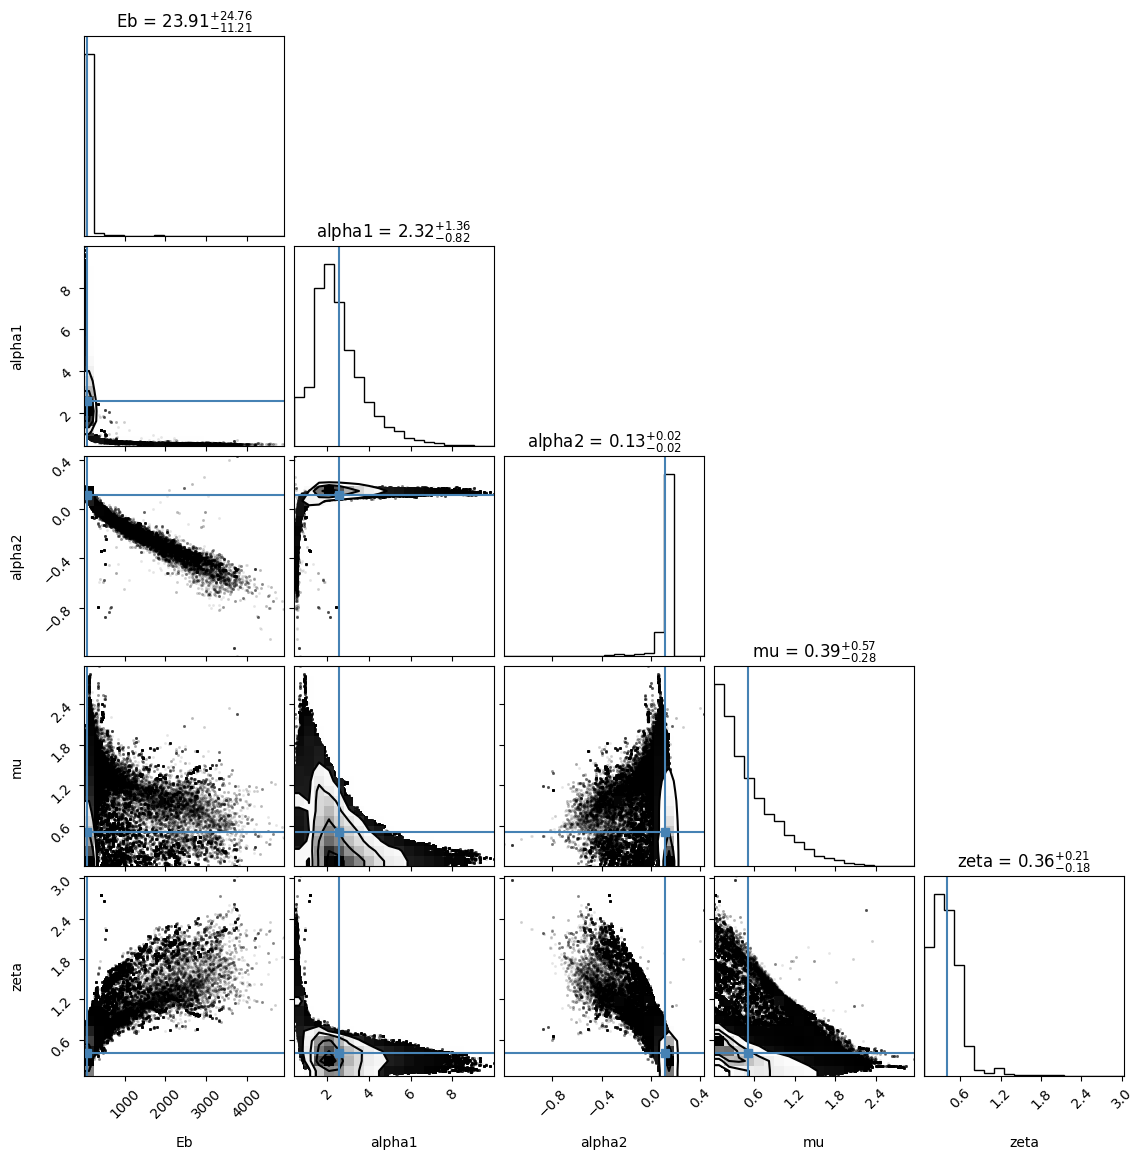

In [9]:
fig = corner(results, labels=['Eb', 'alpha1', 'alpha2', 'mu', 'zeta'], truths=truths, hist_kwargs={'density' : True}, show_titles=True, title_kwargs={"fontsize": 12})